In [1]:
import cv2
from PIL import Image
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
# 랜덤으로 선택한 그림 정보 읽기
art = pd.read_csv('../Data/Artist/csv/current_select.csv')
art.head()

,index,Unnamed: 0,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,26644,26644,Frederic Edwin Church,1866.0,landscape,1280.0,849.0,204102.0,wikiart,Romanticism,Rainy Season in the Tropics,test_only,False,6976.jpg
1,50340,50340,Berthe Morisot,c.1889,landscape,710.0,989.0,152779.0,wikiart,Impressionism,Carriage in the Bois de Boulogne,train_and_test,True,97969.jpg
2,5440,5440,James Tissot,1877,portrait,1590.0,2854.0,371352.0,wikiart,Realism,Mavourneen (Portrait of Kathleen Newton),train_and_test,False,2389.jpg
3,73175,73175,Kazimir Malevich,NaN,abstract,800.0,514.0,106696.0,wikiart,Constructivism,Spatial Suprematism,train_and_test,True,66452.jpg
4,23479,23479,Eyvind Earle,1996.0,landscape,1280.0,950.0,317156.0,wikiart,Magic Realism,Blazing Glory,train_and_test,True,32327.jpg


---
# 회전한 그림을 읽어 train 정보 생성

In [3]:
fileCount = len([name for name in glob.glob('../Data/Artist/train/*.jpg')])
fileCount

2220

In [4]:
height = 400
width = 600
colors = 3

trainData = np.zeros(fileCount * height * width * colors).reshape(-1, height, width, colors)

In [5]:
figure_slt = []
i = 0
for file in sorted(glob.glob('../Data/Artist/train/*.jpg')):
    file_name = file[:file.find('_')].replace('../Data/Artist/train/', '') + '.jpg'
    figure_slt.append(file_name)
    img = np.array(Image.open(file), dtype=np.int32)
    trainData[i] = img
    i += 1


# target 정보 생성

In [6]:
unq_file = list(sorted(set(figure_slt)))
print(len(unq_file))
print(unq_file[:5])

37
['100460.jpg', '100826.jpg', '14702.jpg', '1772.jpg', '18034.jpg']


In [7]:
targetData = []

for file in figure_slt:
    id = [idx for idx in range(len(unq_file)) if file == unq_file[idx]]
    targetData.append(id)

# train, valid, test 데이터로 분리

In [8]:
train = trainData / 255.0

In [9]:
targetData = np.array(targetData).flatten()

In [10]:
trainData, testData, trainTarget, testTarget = train_test_split(
    train, targetData, test_size=0.2, random_state=42
)

trainData, valData, trainTarget, valTarget = train_test_split(
    trainData, trainTarget, test_size=0.2, random_state=42
)

In [11]:
print(trainData.shape)
print(trainTarget.shape)
print(valData.shape)
print(valTarget.shape)
print(testData.shape)
print(testTarget.shape)

(1420, 400, 600, 3)
(1420,)
(356, 400, 600, 3)
(356,)
(444, 400, 600, 3)
(444,)


---
# 딥러닝 모델 생성

In [12]:
model = keras.Sequential()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-08-03 11:59:01.549366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 11:59:01.550477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.add(
    keras.layers.Conv2D(
        32, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
        input_shape = (height, width, colors) 
    )
)

In [14]:
model.add(keras.layers.MaxPooling2D(2))

In [15]:
model.add(
    keras.layers.Conv2D(
        32, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
    )
)

In [16]:
model.add(keras.layers.MaxPooling2D(2))

In [17]:
model.add(
    keras.layers.Conv2D(
        64, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
    )
)

In [18]:
model.add(keras.layers.MaxPooling2D(2))

In [19]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(0.4))  # 50% Drop Out
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(0.4))  # 50% Drop Out
model.add(keras.layers.Dense(len(unq_file), activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 600, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 300, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 300, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 150, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 75, 64)       0

In [21]:
# 모델 학습하기
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics ='accuracy'
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("../Data/Artist/model/figure_46_model.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    trainData, 
    trainTarget, 
    epochs=50, 
    validation_data=[valData, valTarget],
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50


2022-08-03 11:59:08.533180: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-03 11:59:09.009501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - ETA: 0s - loss: 3.3537 - accuracy: 0.1951

2022-08-03 11:59:29.218286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 24s 491ms/step - loss: 3.3537 - accuracy: 0.1951 - val_loss: 1.2456 - val_accuracy: 0.8483
Epoch 2/50
45/45 [==============================] - 21s 452ms/step - loss: 0.8731 - accuracy: 0.7570 - val_loss: 0.0656 - val_accuracy: 1.0000
Epoch 3/50
45/45 [==============================] - 20s 445ms/step - loss: 0.2187 - accuracy: 0.9331 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 4/50
45/45 [==============================] - 20s 450ms/step - loss: 0.0862 - accuracy: 0.9775 - val_loss: 5.3829e-04 - val_accuracy: 1.0000
Epoch 5/50
45/45 [==============================] - 20s 436ms/step - loss: 0.0373 - accuracy: 0.9908 - val_loss: 8.6193e-04 - val_accuracy: 1.0000
Epoch 6/50
45/45 [==============================] - 20s 441ms/step - loss: 0.0420 - accuracy: 0.9894 - val_loss: 4.0714e-04 - val_accuracy: 1.0000
Epoch 7/50
45/45 [==============================] - 20s 445ms/step - loss: 0.0352 - accuracy: 0.9901 - val_loss: 6.5705e-04 - val_accuracy: 1

In [22]:
model.evaluate(testData, testTarget)

14/14 [==============================] - 4s 205ms/step - loss: 8.6483e-05 - accuracy: 1.0000


[8.648283255752176e-05, 1.0]

---
# 학습한 그림 정보 

In [23]:
unq_file[:5]

['100460.jpg', '100826.jpg', '14702.jpg', '1772.jpg', '18034.jpg']

In [24]:
figure_idx = []
for file in unq_file:
    id = [idx for idx in art.index if art.iloc[idx]['new_filename'] == file]
    figure_idx.append(id)

In [25]:
figure_idx = np.array(figure_idx).flatten().tolist()
figure_idx[:5]

[11, 28, 37, 12, 29]

In [26]:
figureData = art.iloc[figure_idx]
figureData.reset_index(drop=True, inplace=True)
figureData.head()
figureData.to_csv('../Data/Artist/model/figure_46_modelData.csv', index=False)

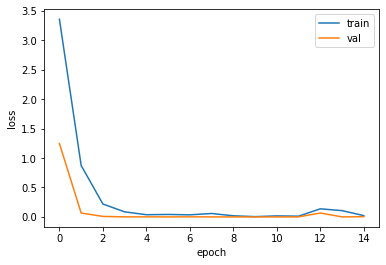

In [27]:
# 시각화 해보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [28]:
model.evaluate(testData, testTarget)

14/14 [==============================] - 3s 207ms/step - loss: 8.6483e-05 - accuracy: 1.0000


[8.648283255752176e-05, 1.0]